In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import default_us_equity_universe_mask
from quantopian.pipeline.data import morningstar, builtin

# Mean correlations of top US equities
This notebook calculates the weighted correlations of top US equities over time. Correlation here is the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which is a measure of how similar two sets of returns are. For example, two stocks with returns that are exactly the same over the past 6 months will have a correlation of 1.0, and two stocks with returns that are completely unrelated will have a correlation close to zero.

The code below will fetch US equities and their market caps for every day over the past 15 years. Then, it loads historical prices for all these stocks. Next, it goes through each day, and gets the top 100, 500, etc. stocks. For all of these stocks, it gets their trailing 6 months of returns from the current day of analysis, and computes their correlations. This gives us a correlation matrix. Finally, it averages the correlation matrix to a single number. To do this, we weight each correlation by the average market cap of the two stocks (zeroing out the same-stock correlations on the diagonals), and take the weighted average of the matrix. Note this analysis takes around 30 minutes to run.

The average correlation of top US equities over time is then plotted.

### Define Pipeline to get market cap of US Equities

In [2]:
class MarketCap(CustomFactor):
    # Pre-declare inputs and window_length
    inputs = [builtin.USEquityPricing.close, morningstar.valuation.shares_outstanding]
    window_length = 1

    # Compute market cap value
    def compute(self, today, assets, out, close, shares):
        out[:] = close[-1] * shares[-1]


def make_pipeline():
    base_universe = default_us_equity_universe_mask()
    return Pipeline(
        columns={
            'market_cap': MarketCap()
        },
        screen=base_universe 
    )

### Run the pipeline

In [3]:
start_date = '2003-01-01'
end_date = pd.Timestamp('today') - pd.Timedelta(days=2)
result = run_pipeline(make_pipeline(), start_date, end_date, chunksize=150)

### Get pricing data

In [4]:
all_names = result.index.get_level_values(1).unique()
all_closes = get_pricing(all_names, start_date=start_date, end_date=end_date).price
all_returns = all_closes.pct_change()

### Run computations

In [5]:
num_names = [10, 50, 100, 250, 500, 1000, 1500] # The top N names to plot
rolling_len = pd.Timedelta(days=365.25 / 2) # 6-month rolling correlation
every_n_days = 5 # Only run every 5 days to speed up the calculation
mean_corrs_dict = {}

i = 0

# Compute the mean correlation every 5 days
for day in result.index.get_level_values(0).unique():
    i += 1
    if i % every_n_days != 0:
        continue

    # Get the top names by market cap for the day
    daily_names = result[result.index.get_level_values(0) == day]
    daily_names.index = daily_names.index.droplevel(0)
    daily_names_sorted = daily_names.sort_values('market_cap', ascending=False)

    date_corrs = {}
    for n in num_names:
        # Take the top n US equities by market cap
        names_sample = daily_names_sorted[:n].index.values
        market_caps_sample = daily_names_sorted[:n].market_cap
        
        # Compute the correlation on the past 6 months of data
        corrs = all_returns[names_sample][(day - rolling_len):day].corr()
        
        # Weight of a correlation is the mean of the stocks' market caps
        weights = pd.DataFrame(index=market_caps_sample.index,
                           columns=market_caps_sample.index,
                           data=(market_caps_sample.values + market_caps_sample[:, None])) / 2

        # We don't want to include self-correlations (on the diagonal), so zero them
        weights.values[[np.arange(len(weights))]*2] = 0

        # Take the weighted average of all the correlations
        weighted_mean_corr = corrs.mul(weights).sum().sum() / weights.sum().sum()
        date_corrs[n] = weighted_mean_corr
    
    mean_corrs_dict[day] = date_corrs

## Weighted correlation between top US equities

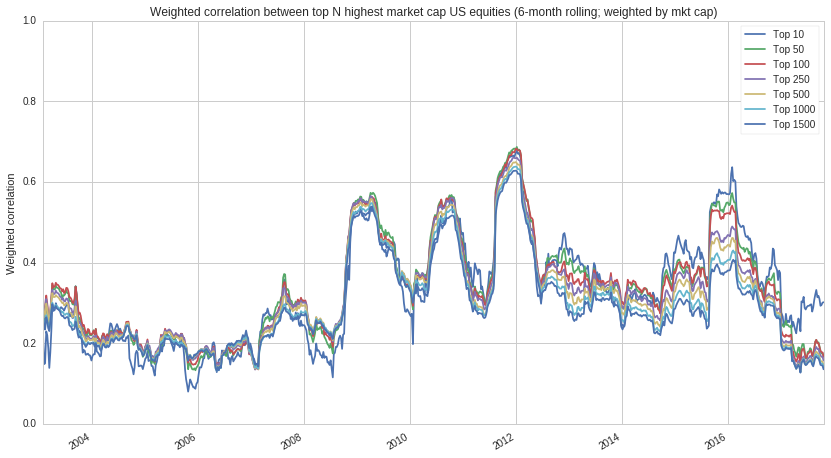

In [6]:
mean_corrs = pd.DataFrame(mean_corrs_dict).T
mean_corrs.plot()

# The beginning is choppy
plt.xlim(pd.Timestamp(start_date) + pd.Timedelta(days=30), end_date);
plt.ylim(0, 1)
plt.title('Weighted correlation between top N highest market cap US equities (6-month rolling; weighted by mkt cap)')
plt.ylabel('Weighted correlation')
plt.legend(['Top %s' % x for x in num_names]);

In general, we can see that the recent correlation is low. This means that recently, stock returns have been more diversified and unrelated to each other. This is considered good for active managers, because there is more diversity in stocks, which gives active managers a larger "effective universe" to pick from.

The periodic spikes from 2009-2012 are curious. We can also see that our lines have spread out recently, which is looked at more closely in the below plot.

## Relative weighted correlation between top US equities

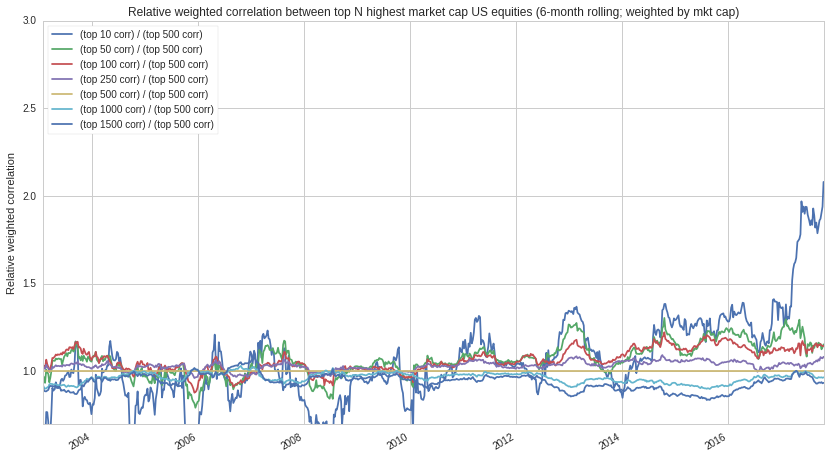

In [7]:
for k in num_names:
    (mean_corrs[k] / mean_corrs[500]).plot(label=k)
plt.legend()

plt.xlim(pd.Timestamp(start_date) + pd.Timedelta(days=30), end_date);
plt.ylim(0.7, 3)
plt.title('Relative weighted correlation between top N highest market cap US equities (6-month rolling; weighted by mkt cap)')
plt.ylabel('Relative weighted correlation')
plt.legend(['(top %s corr) / (top 500 corr)' % x for x in num_names], loc='upper left');

This plot simply takes all the lines above, and divides them by the "top 500" line. So spikes here mean a high correlation relative to a sort-of baseline correlation.

Here, we can see that the relative correlation of the top 10 names has increased significantly recently. I'm not sure why this is the case. One theory is that the explosive growth of passive investing (ie investing in indexes and ETFs) has clustered the top names' supply and demand together, which increases their correlation. But I am so far unconvinced this is the case, since the spike is so sharp — it might just be an effect of the recent consistent market returns.